In [43]:
!pip install matplotlib numpy

Load dataset

In [44]:
import json


songs = {}
files = ["Acide.json", "ACIDE_TECHNO.json", "B2B_M.json", "B2B_M2.json", "Disco.json", "Electro_pop.json", "House-1.json", "Mainstage.json", "Psytrance.json", "Techno.json"]
for file in files:
    with open(f"./playlists/{file}") as f:
        musics = json.load(f)["MUSICS"]
        
        for music_id, music_info in musics.items():
            music = {"genre": music_info["gender"], "title": music_info["title"], "bpm": music_info["bpm"],
                    "key": music_info["key"], "camelot_key": music_info["camelot_key"]}
            skip = False
            for e in music.values():
                if not e:
                    skip = True
                    break
                if e == "" or e == "UNKNOWN" or e == 0:
                    skip = True
                    break
            if not skip:
                songs[music_id] = music

Extraire features  
- Catégorie (ensemble de genre)
- BPM
- Clef (à encoder)

In [45]:
categories = {
    "HOUSE": ["AFROHOUSE", "BASSCLUB", "BASSHOUSE", "DEEPHOUSE", "FUNKYHOUSE", "HOUSE", "JACKINHOUSE", "MELODICHOUSETECHNO", "ORGANICHOUSEDOWNTEMPO", "PROGRESSIVEHOUSE", "TECHHOUSE"],
    "TECHNO": ["TECHNOPEAKTIMEDRIVING", "TECHNORAWDEEPHYPNOTIC", "HARDTECHNO"],
    "TRANCE": ["TRANCEMAINFLOOR", "TRANCERAWDEEPHYPNOTIC", "PSYTRANCE"],
    "DUBSTEP": ["140DEEPDUBSTEPGRIME", "DRUMBASS", "DUBSTEP"],
    "EDM": ["ELECTROCLASSICDETROITMODERN", "MAINSTAGE"],
    "DANCE": ["DANCEELECTROPOP", "INDIEDANCE", "HARDCORE"],
}

count = {"HOUSE": 0, "TECHNO": 0, "TRANCE": 0, "DUBSTEP": 0, "EDM": 0, "DANCE": 0, "OTHER": 0}

In [46]:
for song in songs.values():
    found = False
    genre = song["genre"]
    for category, genres in categories.items():
        if genre in genres:
            song["category"] = category
            count[category] += 1
            found = True
            break
    if not found:
        song["category"] = "OTHER"
        count["OTHER"] += 1

<BarContainer object of 7 artists>

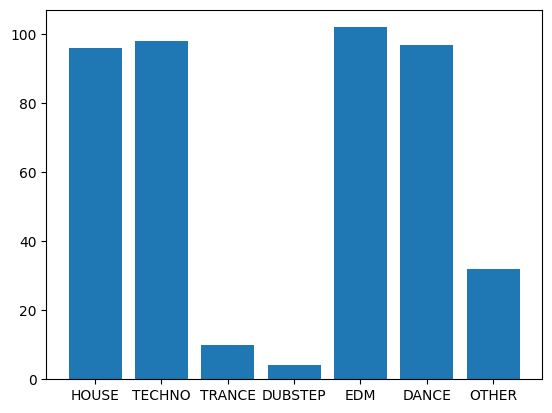

In [47]:
import matplotlib.pyplot as plt

plt.bar(count.keys(), count.values(), align="center")

Définition fonction distance
Calcul de la distance pour toutes les paires possibles

In [73]:
def compute_song_distance(song1, song2):
    camelot_wheel = ['1A', '2A', '3A', '4A', '5A', '6A', '7A', '8A', '9A', '10A', '11A', '12A',
                     '1B', '2B', '3B', '4B', '5B', '6B', '7B', '8B', '9B', '10B', '11B', '12B']

    index1 = camelot_wheel.index(song1["camelot_key"].upper())
    index2 = camelot_wheel.index(song2["camelot_key"].upper())

    identical = index1 == index2
    adjacent = abs(index1 - index2) == 1 or abs(index1 - index2) == len(camelot_wheel) - 1

    bpm_difference = abs(song1['bpm'] - song2['bpm'])

    same_genre = song1['genre'] == song2['genre']
    same_category = song1['category'] == song2['category'] and song1['category'] != "OTHER"

    # TODO: optimize weights
    distance = (not identical and not adjacent) + 0.2 * bpm_difference + 0.5 * (not same_category) + 0.5 * (not same_genre)

    return distance

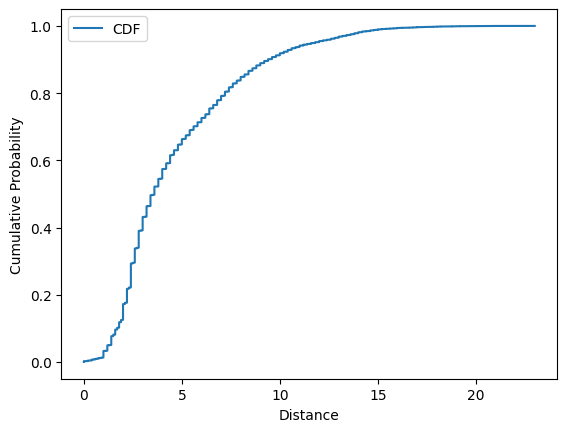

In [74]:
import numpy as np


distance = []
for songA in songs.values():
    for songB in songs.values():
        if songA != songB:
            distance.append(compute_song_distance(songA, songB))

sorted_distances = np.sort(distance)
cumulative_distribution = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)

plt.plot(sorted_distances, cumulative_distribution, label='CDF')

plt.xlabel('Distance')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.show()

Calcul du score

In [75]:
def get_match_score(songA, songB):
    target_distance = compute_song_distance(songA, songB)
    index = np.argmax(sorted_distances >= target_distance)
    
    percentage_above_distance = 100 * (1 - (index / len(sorted_distances)))

    return percentage_above_distance

In [76]:
songA = {
    "key": "Gb MAJ",
    "camelot_key": "2B",
    "bpm": 126,
    "genre": "DEEPHOUSE",
    "category": "HOUSE"}
songB = {
    "key": "Ab MIN",
    "camelot_key": "1A",
    "bpm": 124,
    "genre": "MELODICHOUSETECHNO",
    "category": "HOUSE"}

score = get_match_score(songA, songB)
print(f"Match score:{score}%")

target:1.9
len:192222
index:22696
Match score:88.19281872002163%


# TODO: tester et vérifier en écoutant
# TODO: traiter le son (mfcc??)
# TODO: regarder le state of the art